In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [31]:

import json
import math
import os
import socket
import sys
import time
import datetime
import uuid
from argparse import ArgumentParser
import setproctitle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection
import json

internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import shutil
from utils.args import add_management_args, add_rehearsal_args
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from utils.stil_losses import *
from utils.nets import *
from utils.eval import evaluate, validation_and_agreement, distance_models, evaluate_regression


from sklearn.datasets import *
from sklearn import linear_model



In [175]:
logs_path = './logs/results/regression/linear/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [176]:
res_df = pd.DataFrame(results)
res_df

problem_type      N  buffer_size    D    G  C effective_rank  noise  \
0      regression  10000          100  500  100  1           None    1.0   
1      regression  10000          100  500  100  1           None    1.0   
2      regression  10000          100  500  100  1           None    1.0   
3      regression  10000           10  500  100  1           None    0.1   
4      regression  10000           10  500  100  1           None    0.5   
...           ...    ...          ...  ...  ... ..            ...    ...   
2097   regression  10000         4000  500  100  1           None    1.0   
2098   regression  10000         4000  500  100  1           None   10.0   
2099   regression  10000         4000  500  100  1           None    2.0   
2100   regression  10000         4000  500  100  1           None    5.0   
2101   regression  10000         4000  500  100  1           None    2.0   

      data_seed  alpha  ...            conf_host  final_val_acc_D  \
0            13    1.0  ...  porcino.inf.ethz.ch         1.028533   
1            13    0.0  ...  porcino.inf.ethz.ch         1.028533   
2            13    1.0  ...  porcino.inf.ethz.ch         1.028533   
3            13    0.0  ...  porcino.inf.ethz.ch         0.010285   
4            13    0.0  ...  porcino.inf.ethz.ch         0.257133   
...         ...    ...  ...                  ...              ...   
2097         13    1.0  ...  porcino.inf.ethz.ch         1.028533   
2098         13    1.0  ...  porcino.inf.ethz.ch       102.853309   
2099         13    1.0  ...  porcino.inf.ethz.ch         4.114132   
2100         13    1.0  ...  porcino.inf.ethz.ch        25.713327   
2101         13    1.0  ...  porcino.inf.ethz.ch         4.114132   

     final_distance_teacher_optimum  \
0                          0.216912   
1                          0.216912   
2                          0.216912   
3                          0.021691   
4                          0.108456   
...                             ...   
2097                       0.216912   
2098                       2.169117   
2099                       0.433823   
2100                       1.084558   
2101                       0.433823   

                                              wandb_url  buffer_train_time  \
0     https://wandb.ai/continually/DataEfficientDist...           0.026477   
1     https://wandb.ai/continually/DataEfficientDist...           0.021650   
2     https://wandb.ai/continually/DataEfficientDist...           0.020811   
3     https://wandb.ai/continually/DataEfficientDist...           0.007895   
4     https://wandb.ai/continually/DataEfficientDist...           0.007410   
...                                                 ...                ...   
2097                                                NaN           0.617172   
2098                                                NaN           0.514844   
2099                                                NaN           0.680441   
2100                                                NaN           0.619156   
2101                                                NaN           0.540426   

      final_train_acc_S  final_train_leftout_acc_S  final_val_acc_S  \
0          1.730947e-24              303290.368693    306218.901989   
1          1.170468e+00              279130.892653    280408.215446   
2          1.839585e-24              261104.063355    262601.843171   
3          1.863646e-02              633974.690106    644077.179056   
4          4.659115e-01              633969.915744    644071.919708   
...                 ...                        ...              ...   
2097       8.679778e-01                   1.164172         1.118107   
2098       8.679778e+01                 116.417177       111.810699   
2099       3.471911e+00                   4.656687         4.472428   
2100       2.169944e+01                  29.104294        27.952675   
2101       3.487171e+00                   4.554860         4.515727   

    

In [177]:
res_df.columns

Index(['problem_type', 'N', 'buffer_size', 'D', 'G', 'C', 'effective_rank',
       'noise', 'data_seed', 'alpha', 'gpus_id', 'seed', 'notes',
       'non_verbose', 'disable_log', 'validation', 'ignore_other_metrics',
       'debug_mode', 'nowand', 'wandb_entity', 'wandb_project', 'wandb_name',
       'conf_jobnum', 'conf_timestamp', 'conf_host', 'final_val_acc_D',
       'final_distance_teacher_optimum', 'wandb_url', 'buffer_train_time',
       'final_train_acc_S', 'final_train_leftout_acc_S', 'final_val_acc_S',
       'final_distance_teacher_student', 'final_distance_student_optimum'],
      dtype='object')

In [178]:
SEEDS = [11, 13, 21, 33, 55 ,5,138,228,196,118]
BUFFER_SIZES = [10, 100, 500, 1000, 20000, 30000, 40000]
NOISE = [0.0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

In [179]:
res_df['buffer_size_p'] = res_df['buffer_size']/(10000)
res_df['generalization_gap'] = res_df['final_val_acc_S']-res_df['final_train_acc_S']
res_df['buffer_gap'] = res_df['final_train_leftout_acc_S']-res_df['final_train_acc_S']
res_df['final_val_acc_S_p'] = 100*res_df['final_val_acc_S']/(res_df['final_val_acc_D'])
res_df['final_train_acc_S_p'] = 100*res_df['final_train_acc_S']/(res_df['final_val_acc_D'])

In [180]:
res_df['buffer_size_p'].unique(), res_df['noise'].unique()


(array([0.01 , 0.001, 0.05 , 0.1  , 0.2  , 0.02 , 0.03 , 0.04 , 0.06 ,
        0.07 , 0.08 , 0.09 , 0.3  , 0.4  ]),
 array([ 1. ,  0.1,  0.5,  0. ,  5. ,  2. , 10. ]))

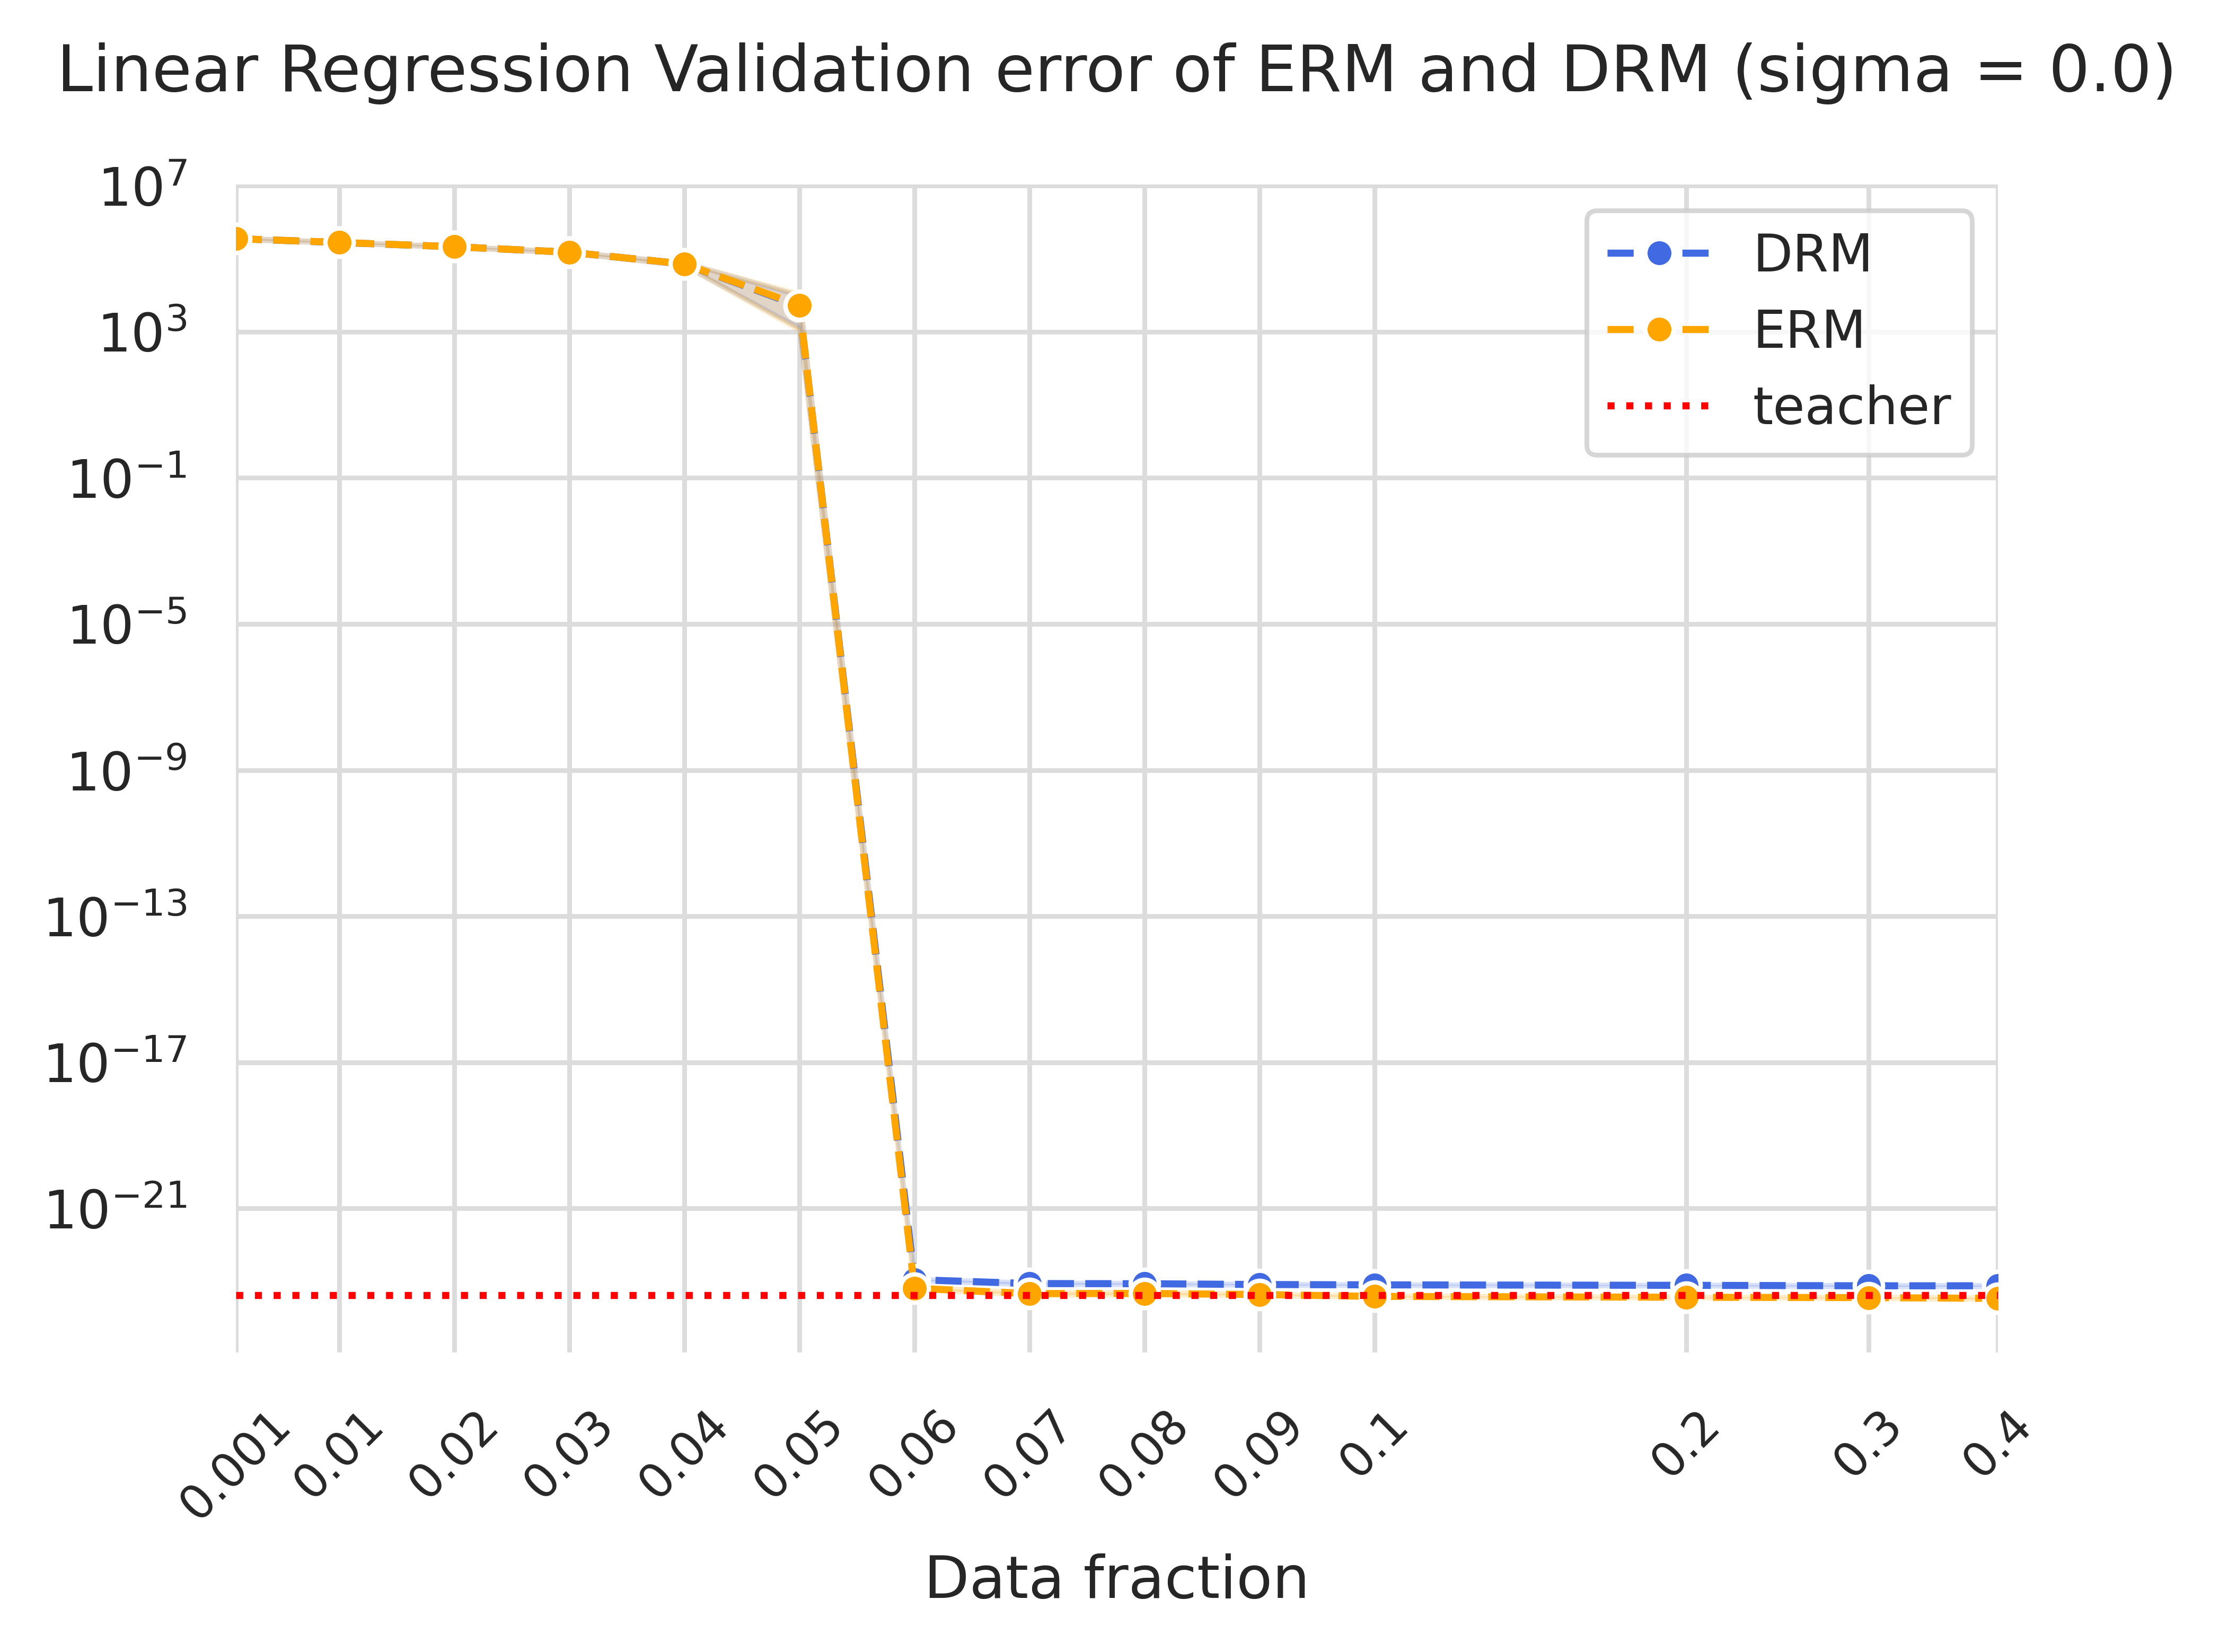

In [181]:
min_max = lambda x: (x.min(), x.max())
noise = .0
working_df = res_df.loc[res_df['noise']==noise]
teacher_val_accuracy = list(working_df['final_val_acc_D'])[0]
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="ci",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
    #              markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="ci",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
    #             markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    ax.axhline(teacher_val_accuracy, ls=':', color='red', label="teacher.error")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_yscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    #ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    # yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    # plt.yticks(yticks)
    # ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    #ax.set_ylim(-100,1000000.0)


    ax.set_title(f"Linear Regression Validation error of ERM and DRM (sigma = {noise})", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Data fraction', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="upper right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('red')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


In [182]:
sorted(list(res_df['noise'].unique()))

[0.0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

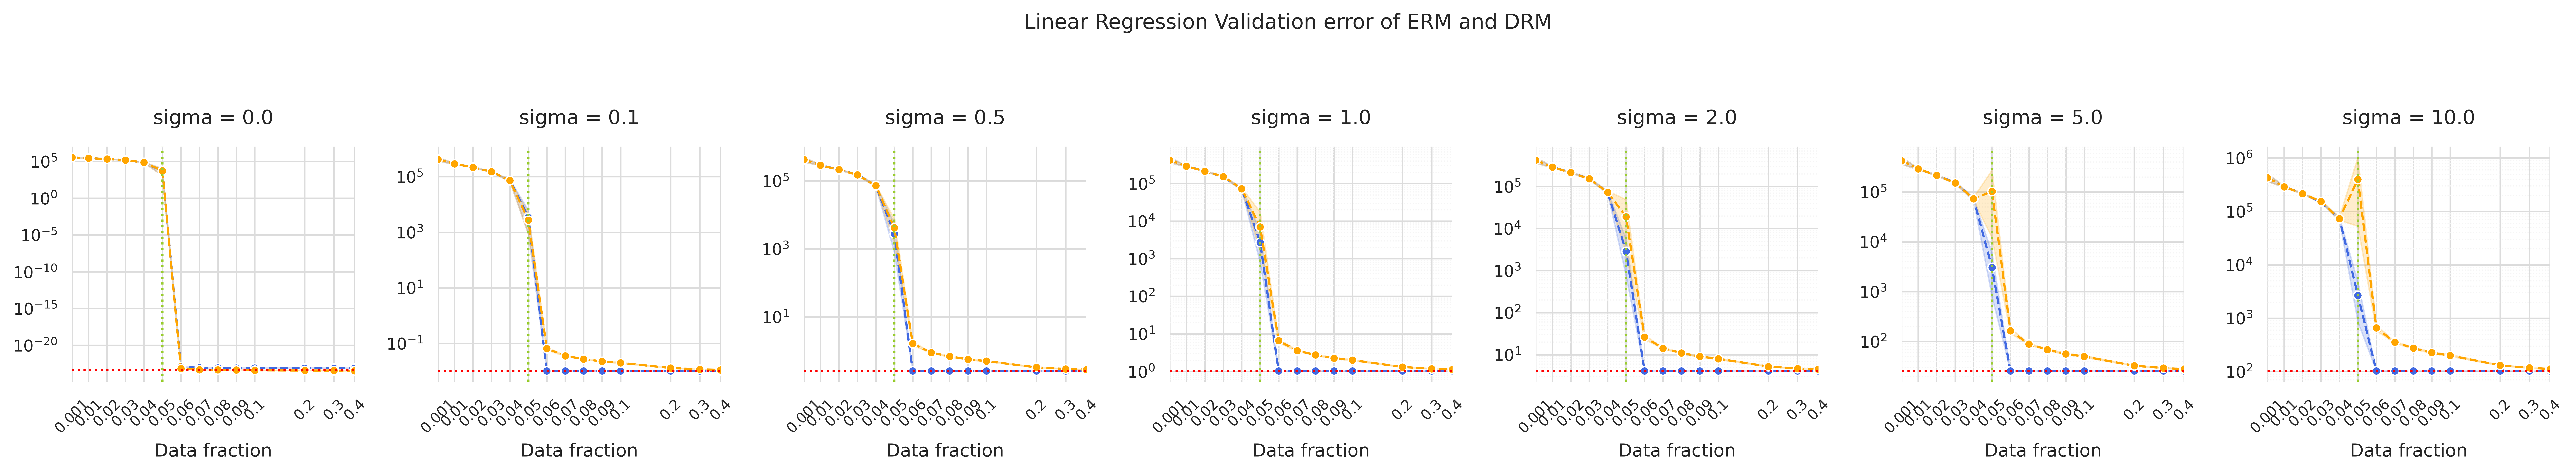

In [183]:
noise_list = sorted(list(res_df['noise'].unique()))

min_max = lambda x: (x.min(), x.max())
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,len(noise_list), figsize=(20,3), sharey=False, dpi=800)
    colors = ['royalblue','orange','dimgray']

    for i, noise in enumerate(noise_list):
      working_df = res_df.loc[res_df['noise']==noise]
      teacher_val_accuracy = list(working_df['final_val_acc_D'])[0]
      _df = working_df.loc[working_df['alpha']==0.0]
      sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="ci",
                  markers=True, marker='o', color=colors[0], ls='--',ax=ax[i], label="distil.val")
      # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
      #              markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
      _df = working_df.loc[working_df['alpha']==1.0]
      sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="ci",
                  markers=True, marker='o', color=colors[1], ls='--', ax=ax[i], label="labels.val")
      # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
      #             markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
      
      ax[i].axvline(0.05, ls=':', color='yellowgreen', label="0")
      #ax.axvline(100.0, ls='--', color='tab:green')
      # ax.axhline(76.034, ls='--', color=colors[2], label="a")
      ax[i].axhline(teacher_val_accuracy, ls=':', color='red', label="teacher.error")
      # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
      # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
      #            fontsize=10, verticalalignment='top', bbox=props)
      ax[i].set_yscale('log')
      ax[i].set_xscale('symlog',linthresh=10e-2)
      ax[i].set_xlim([0.1,0.4])
      #ax.set_ylim([0.0,100.0])

      ax[i].tick_params(axis='both',  labelsize=9)
      ax[i].set_xticks(working_df['buffer_size_p'].unique())
      ax[i].set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
      ax[i].tick_params(axis='x',  rotation=45)

      # yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
      # plt.yticks(yticks)
      # ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



      # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
      #ax.set_ylim(-100,1000000.0)


      ax[i].set_title(f"sigma = {noise}", fontsize=11, y=1.05)
      ax[i].set_ylabel(r'', fontsize=11, x=-0.2)
      ax[i].set_xlabel(r'Data fraction', fontsize=10, y=+5)


      #ax[t].legend(title="Eigen-index", loc="upper left")
      # Shrink current axis's height by 10% on the bottom
      if i==len(noise_list):
        h, _ = ax.get_legend_handles_labels()
        ax[i].legend(h, ['DRM.val',
                      'ERM.val',
                      'teacher.val'], 
                    title="", ncol=1, loc="upper right")
      else: ax[i].get_legend().remove()


      # AESTHETICS control 
      ax[i].set_facecolor('white')
      [ax[i].spines[side].set_visible(False) for side in ax[i].spines]
      # major and minor grids
      ax[i].grid(which='major', color='gainsboro', linewidth=0.8)
      ax[i].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
      # Make the minor ticks and gridlines show.
      ax[i].minorticks_on()
      #ax.tick_params(which='minor', bottom=False, left=False)
      #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

      # a = ax.get_ygridlines()
      # b = a[3]
      # b.set_color('red')
      # b.set_linewidth(0.8)
      # b.set_linestyle(':')
      #sns.despine()
      plt.tight_layout()
    plt.suptitle("Linear Regression Validation error of ERM and DRM", y=1.2)


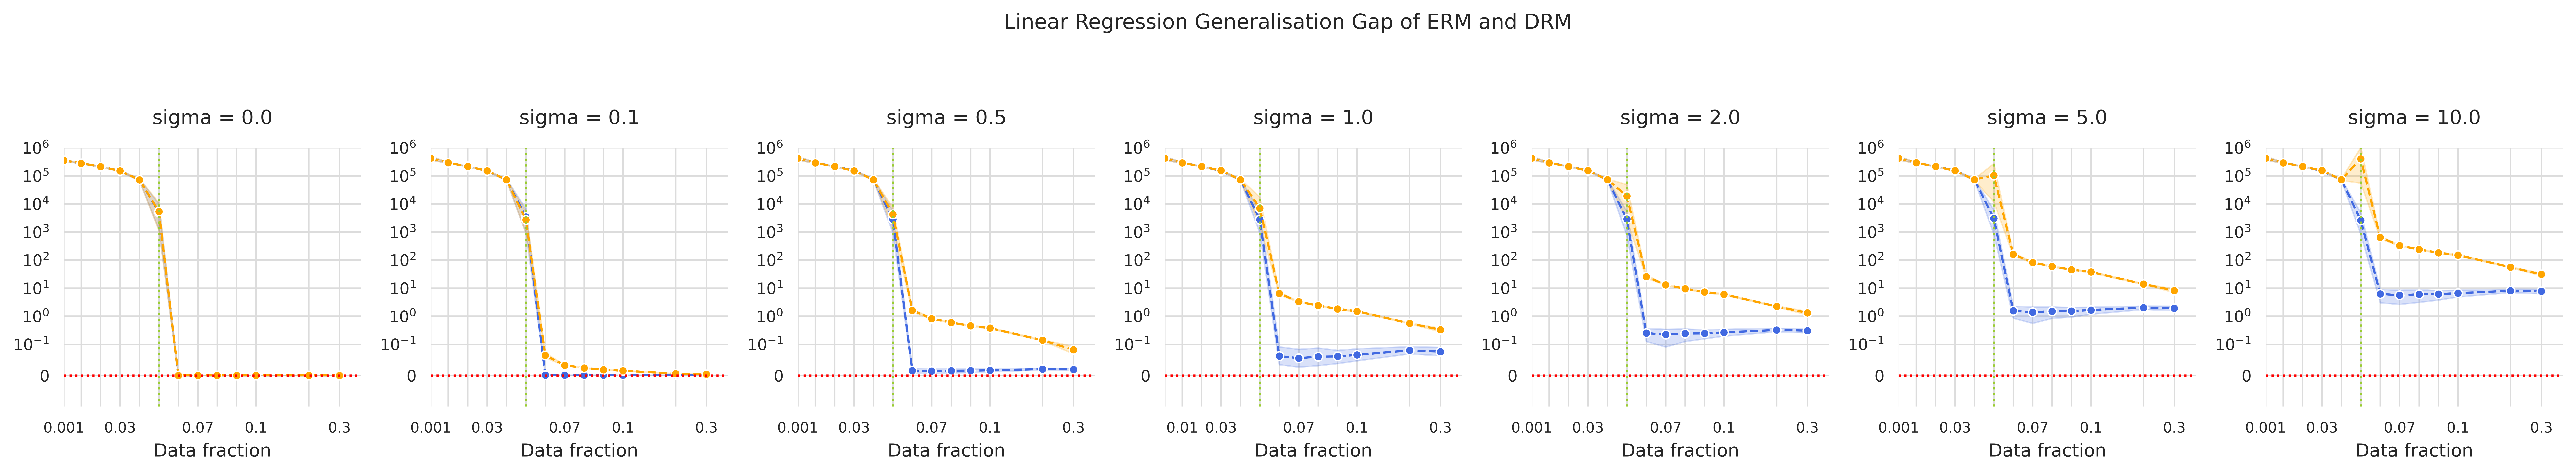

In [174]:
noise_list = sorted(list(res_df['noise'].unique()))

min_max = lambda x: (x.min(), x.max())
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,len(noise_list), figsize=(20,3), sharey=False, dpi=800)
    colors = ['royalblue','orange','dimgray']

    for i, noise in enumerate(noise_list):
      working_df = res_df.loc[res_df['noise']==noise]
      teacher_val_accuracy = list(working_df['final_val_acc_D'])[0]
      _df = working_df.loc[working_df['alpha']==0.0]
      sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="ci",
                  markers=True, marker='o', color=colors[0], ls='--',ax=ax[i], label="distil.val")
      # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
      #              markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
      _df = working_df.loc[working_df['alpha']==1.0]
      sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="ci",
                  markers=True, marker='o', color=colors[1], ls='--', ax=ax[i], label="labels.val")
      # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
      #             markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
      

      #ax.axvline(100.0, ls='--', color='tab:green')
      # ax.axhline(76.034, ls='--', color=colors[2], label="a")
      ax[i].axvline(0.05, ls=':', color='yellowgreen', label="0")
      ax[i].axhline(0.0, ls=':', color='red', label="0")
      # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
      # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
      #            fontsize=10, verticalalignment='top', bbox=props)
      ax[i].set_yscale('symlog',linthresh=10e-2)
      ax[i].set_xscale('symlog',linthresh=10e-2)
      ax[i].set_xlim([0.1,0.4])
      ax[i].set_ylim([-.1,1000000.0])

      #ax[i].tick_params(axis='both',  labelsize=9)
      ax[i].set_xticks(working_df['buffer_size_p'].unique())
      ax[i].set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
      every_nth = 3
      for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
          if n % every_nth != 0:
              label.set_visible(False)
      #ax[i].tick_params(axis='x',  rotation=45)

      # yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
      # plt.yticks(yticks)
      # ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



      # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
      #ax.set_ylim(-100,1000000.0)


      ax[i].set_title(f"sigma = {noise}", fontsize=11, y=1.05)
      ax[i].set_ylabel(r'', fontsize=11, x=-0.2)
      ax[i].set_xlabel(r'Data fraction', fontsize=10, y=+5)


      #ax[t].legend(title="Eigen-index", loc="upper left")
      # Shrink current axis's height by 10% on the bottom
      if i==len(noise_list):
        h, _ = ax.get_legend_handles_labels()
        ax[i].legend(h, ['DRM.val',
                      'ERM.val',
                      'teacher.val'], 
                    title="", ncol=1, loc="upper right")
      else: ax[i].get_legend().remove()


      # AESTHETICS control 
      ax[i].set_facecolor('white')
      [ax[i].spines[side].set_visible(False) for side in ax[i].spines]
      # major and minor grids
      ax[i].grid(which='major', color='gainsboro', linewidth=0.8)
      ax[i].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
      # Make the minor ticks and gridlines show.
      ax[i].minorticks_on()
      #ax.tick_params(which='minor', bottom=False, left=False)
      #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

      # a = ax.get_ygridlines()
      # b = a[3]
      # b.set_color('red')
      # b.set_linewidth(0.8)
      # b.set_linestyle(':')
      #sns.despine()
      plt.tight_layout()
    plt.suptitle("Linear Regression Generalisation Gap of ERM and DRM", y=1.2)


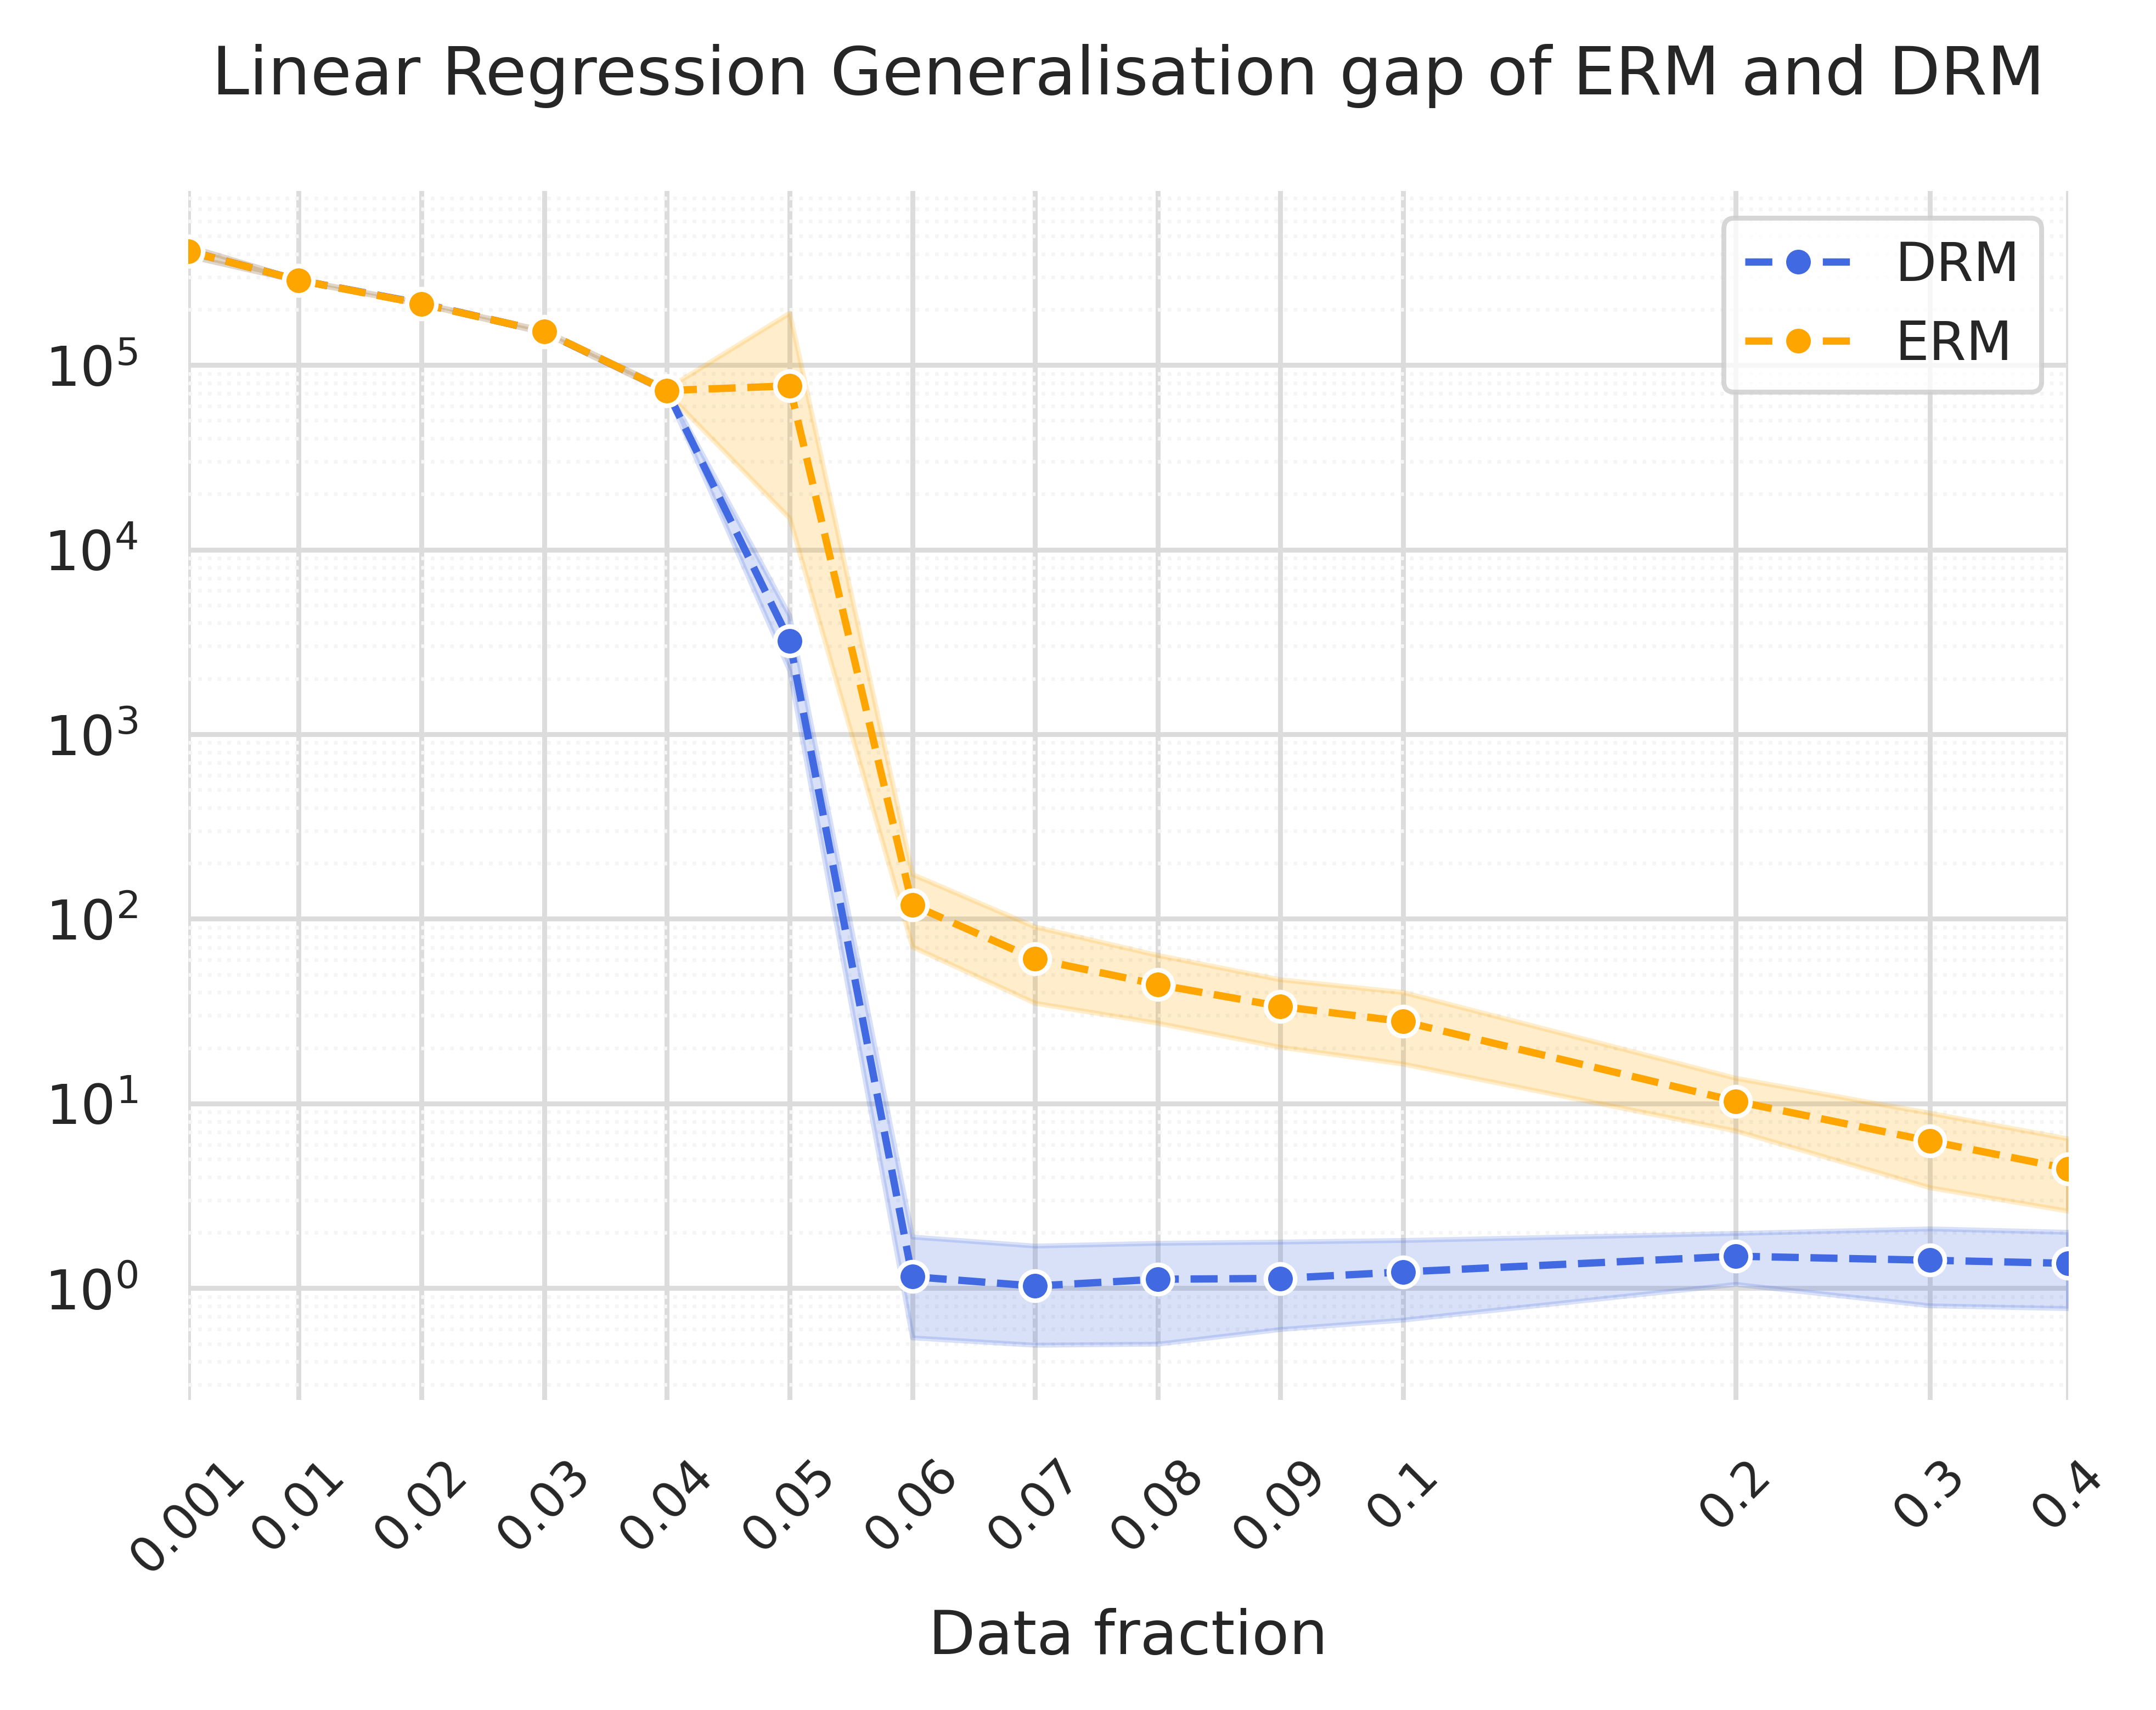

In [184]:
min_max = lambda x: (x.min(), x.max())
noise = .0
working_df = res_df#.loc[res_df['noise']==noise]
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="ci",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
    #              markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="ci",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
    #             markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    ax.axhline(0.0, ls=':', color='red', label="0")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_yscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    #ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    # yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    # plt.yticks(yticks)
    # ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    #ax.set_ylim(-100,1000000.0)


    ax.set_title(f"Linear Regression Generalisation gap of ERM and DRM", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Data fraction', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM'], 
                title="", ncol=1, loc="upper right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('red')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


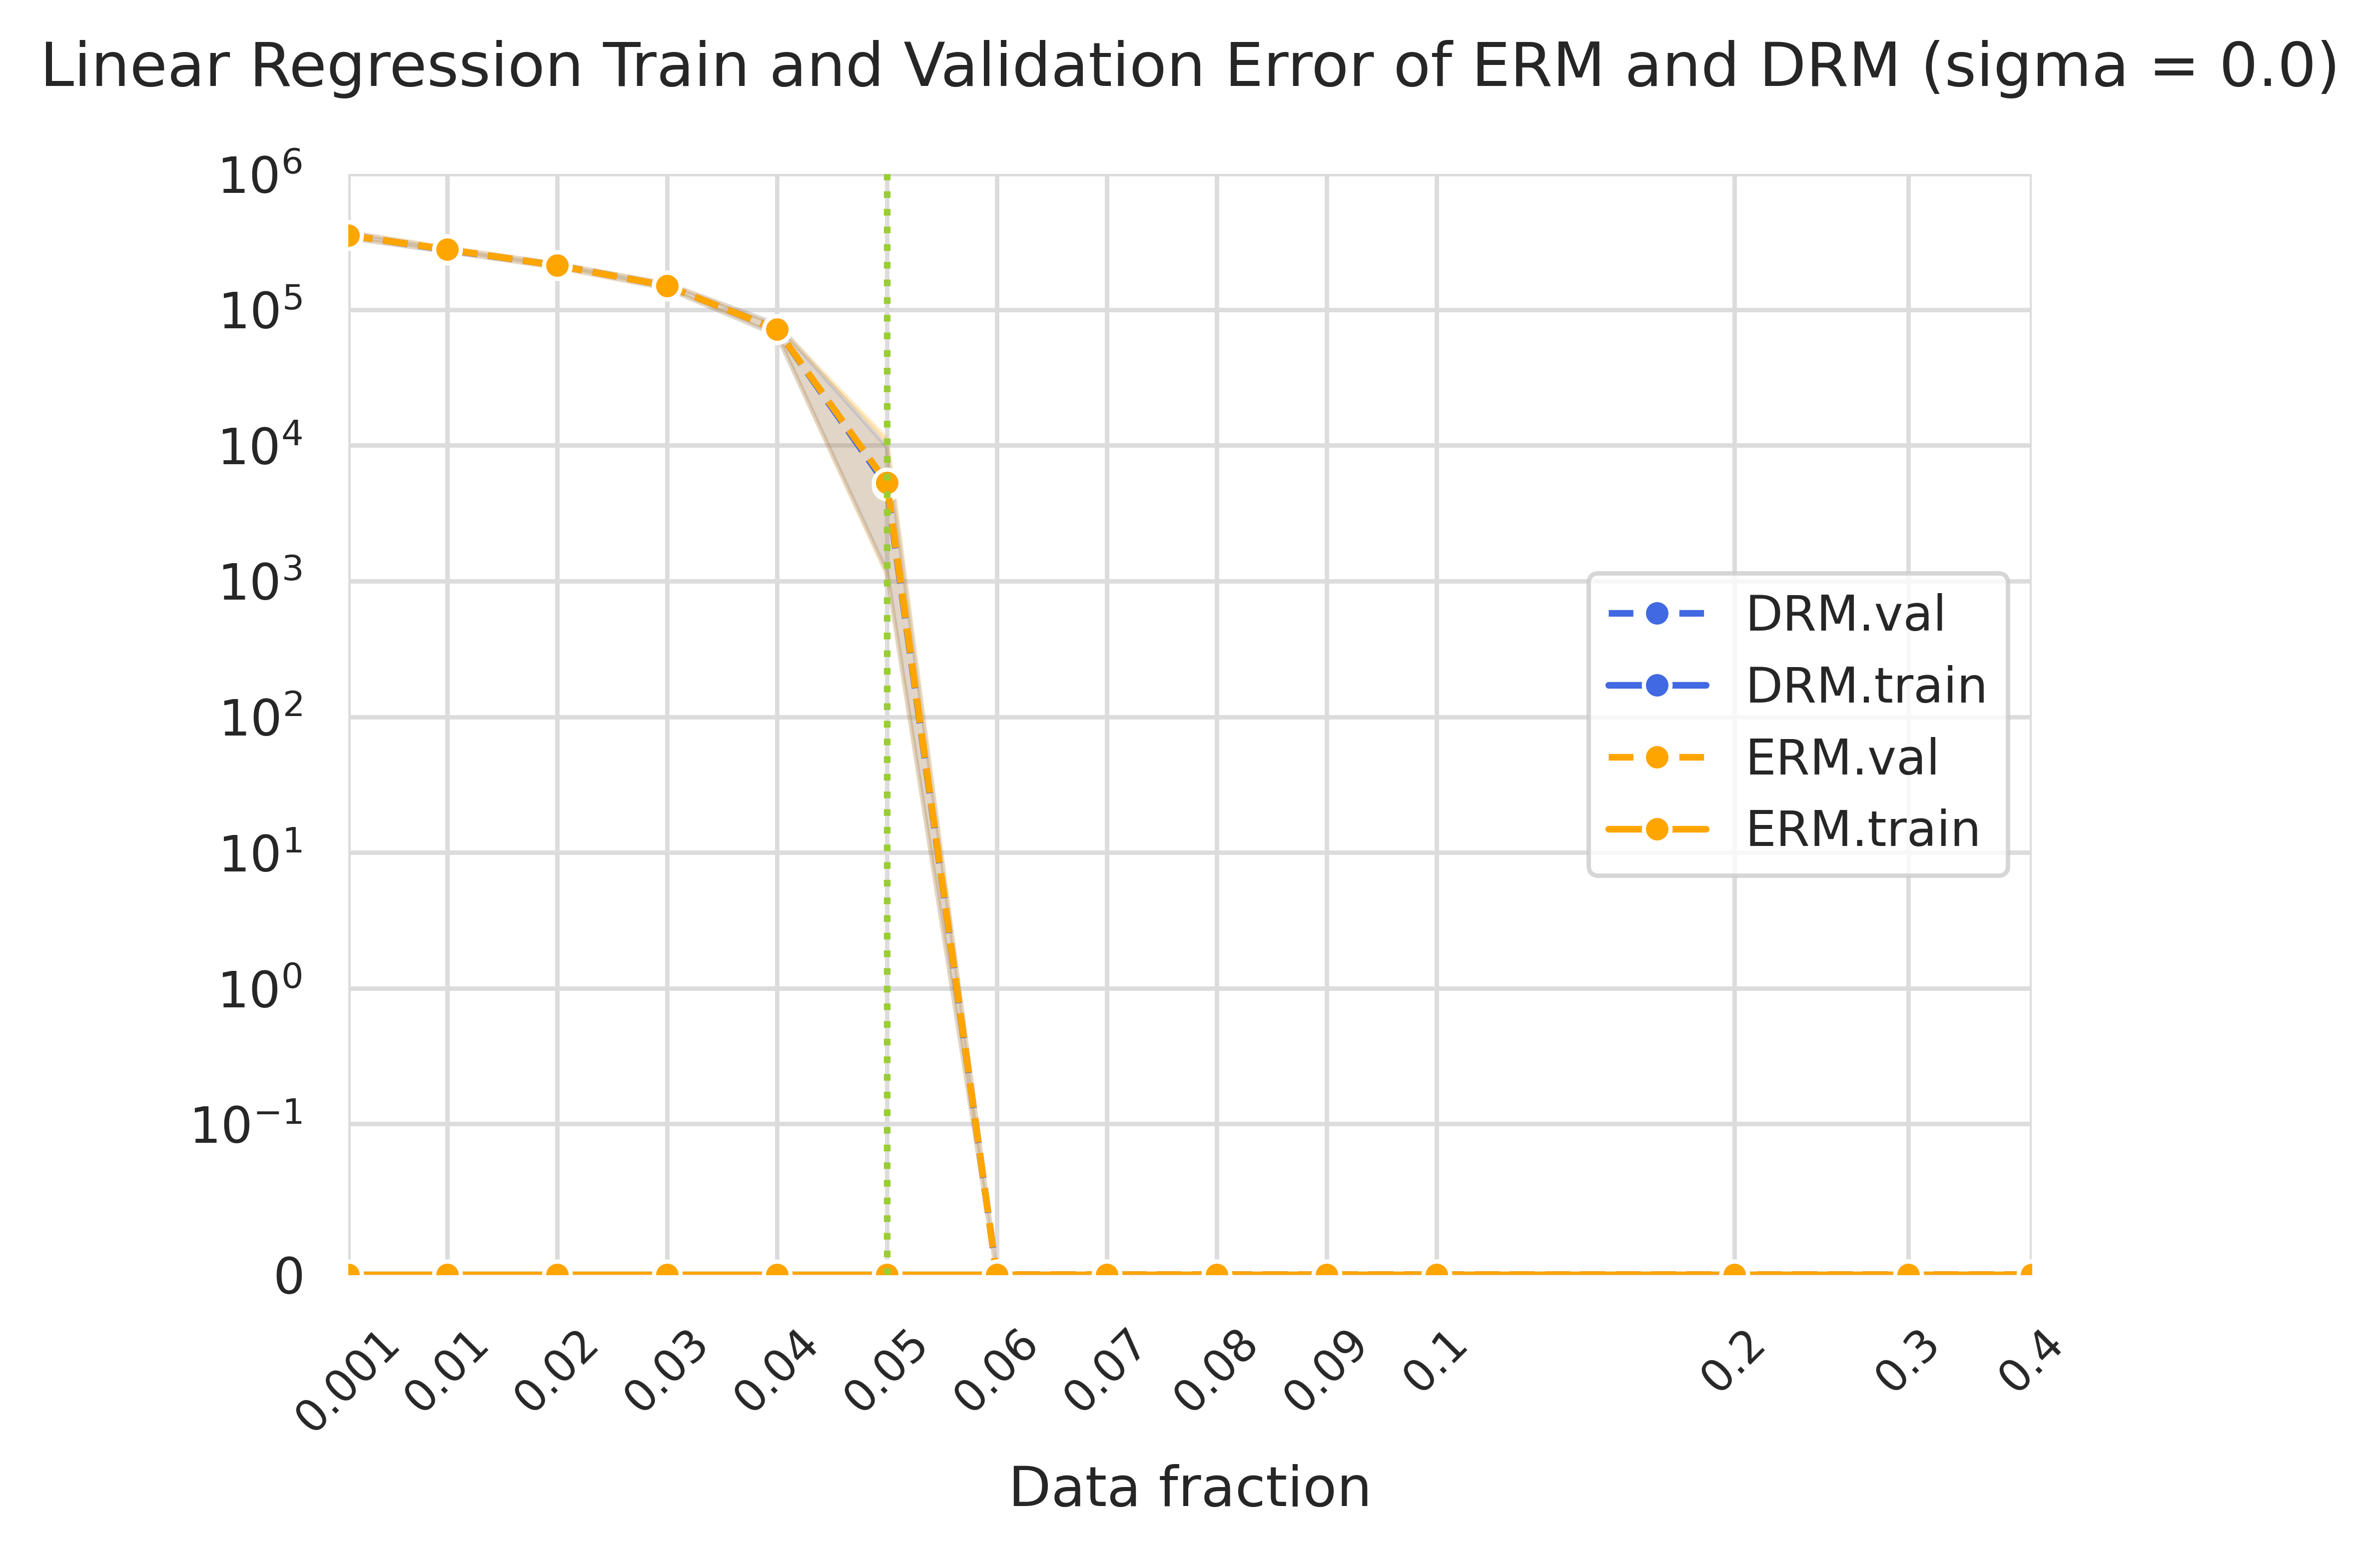

In [185]:
min_max = lambda x: (x.min(), x.max())
noise = 0.0
working_df = res_df.loc[res_df['noise']==noise]
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="ci",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="ci",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    ax.axvline(0.05, ls=':', color='yellowgreen', label="0")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_yscale('symlog',linthresh=10e-2)
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,1000000.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    # yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    # plt.yticks(yticks)
    # ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    #ax.set_ylim(-100,1000000.0)


    ax.set_title(f"Linear Regression Train and Validation Error of ERM and DRM (sigma = {noise})", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Data fraction', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM.val',
                  'DRM.train',
                  'ERM.val',
                  'ERM.train'], 
                title="", ncol=1, loc="center right")

    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('red')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


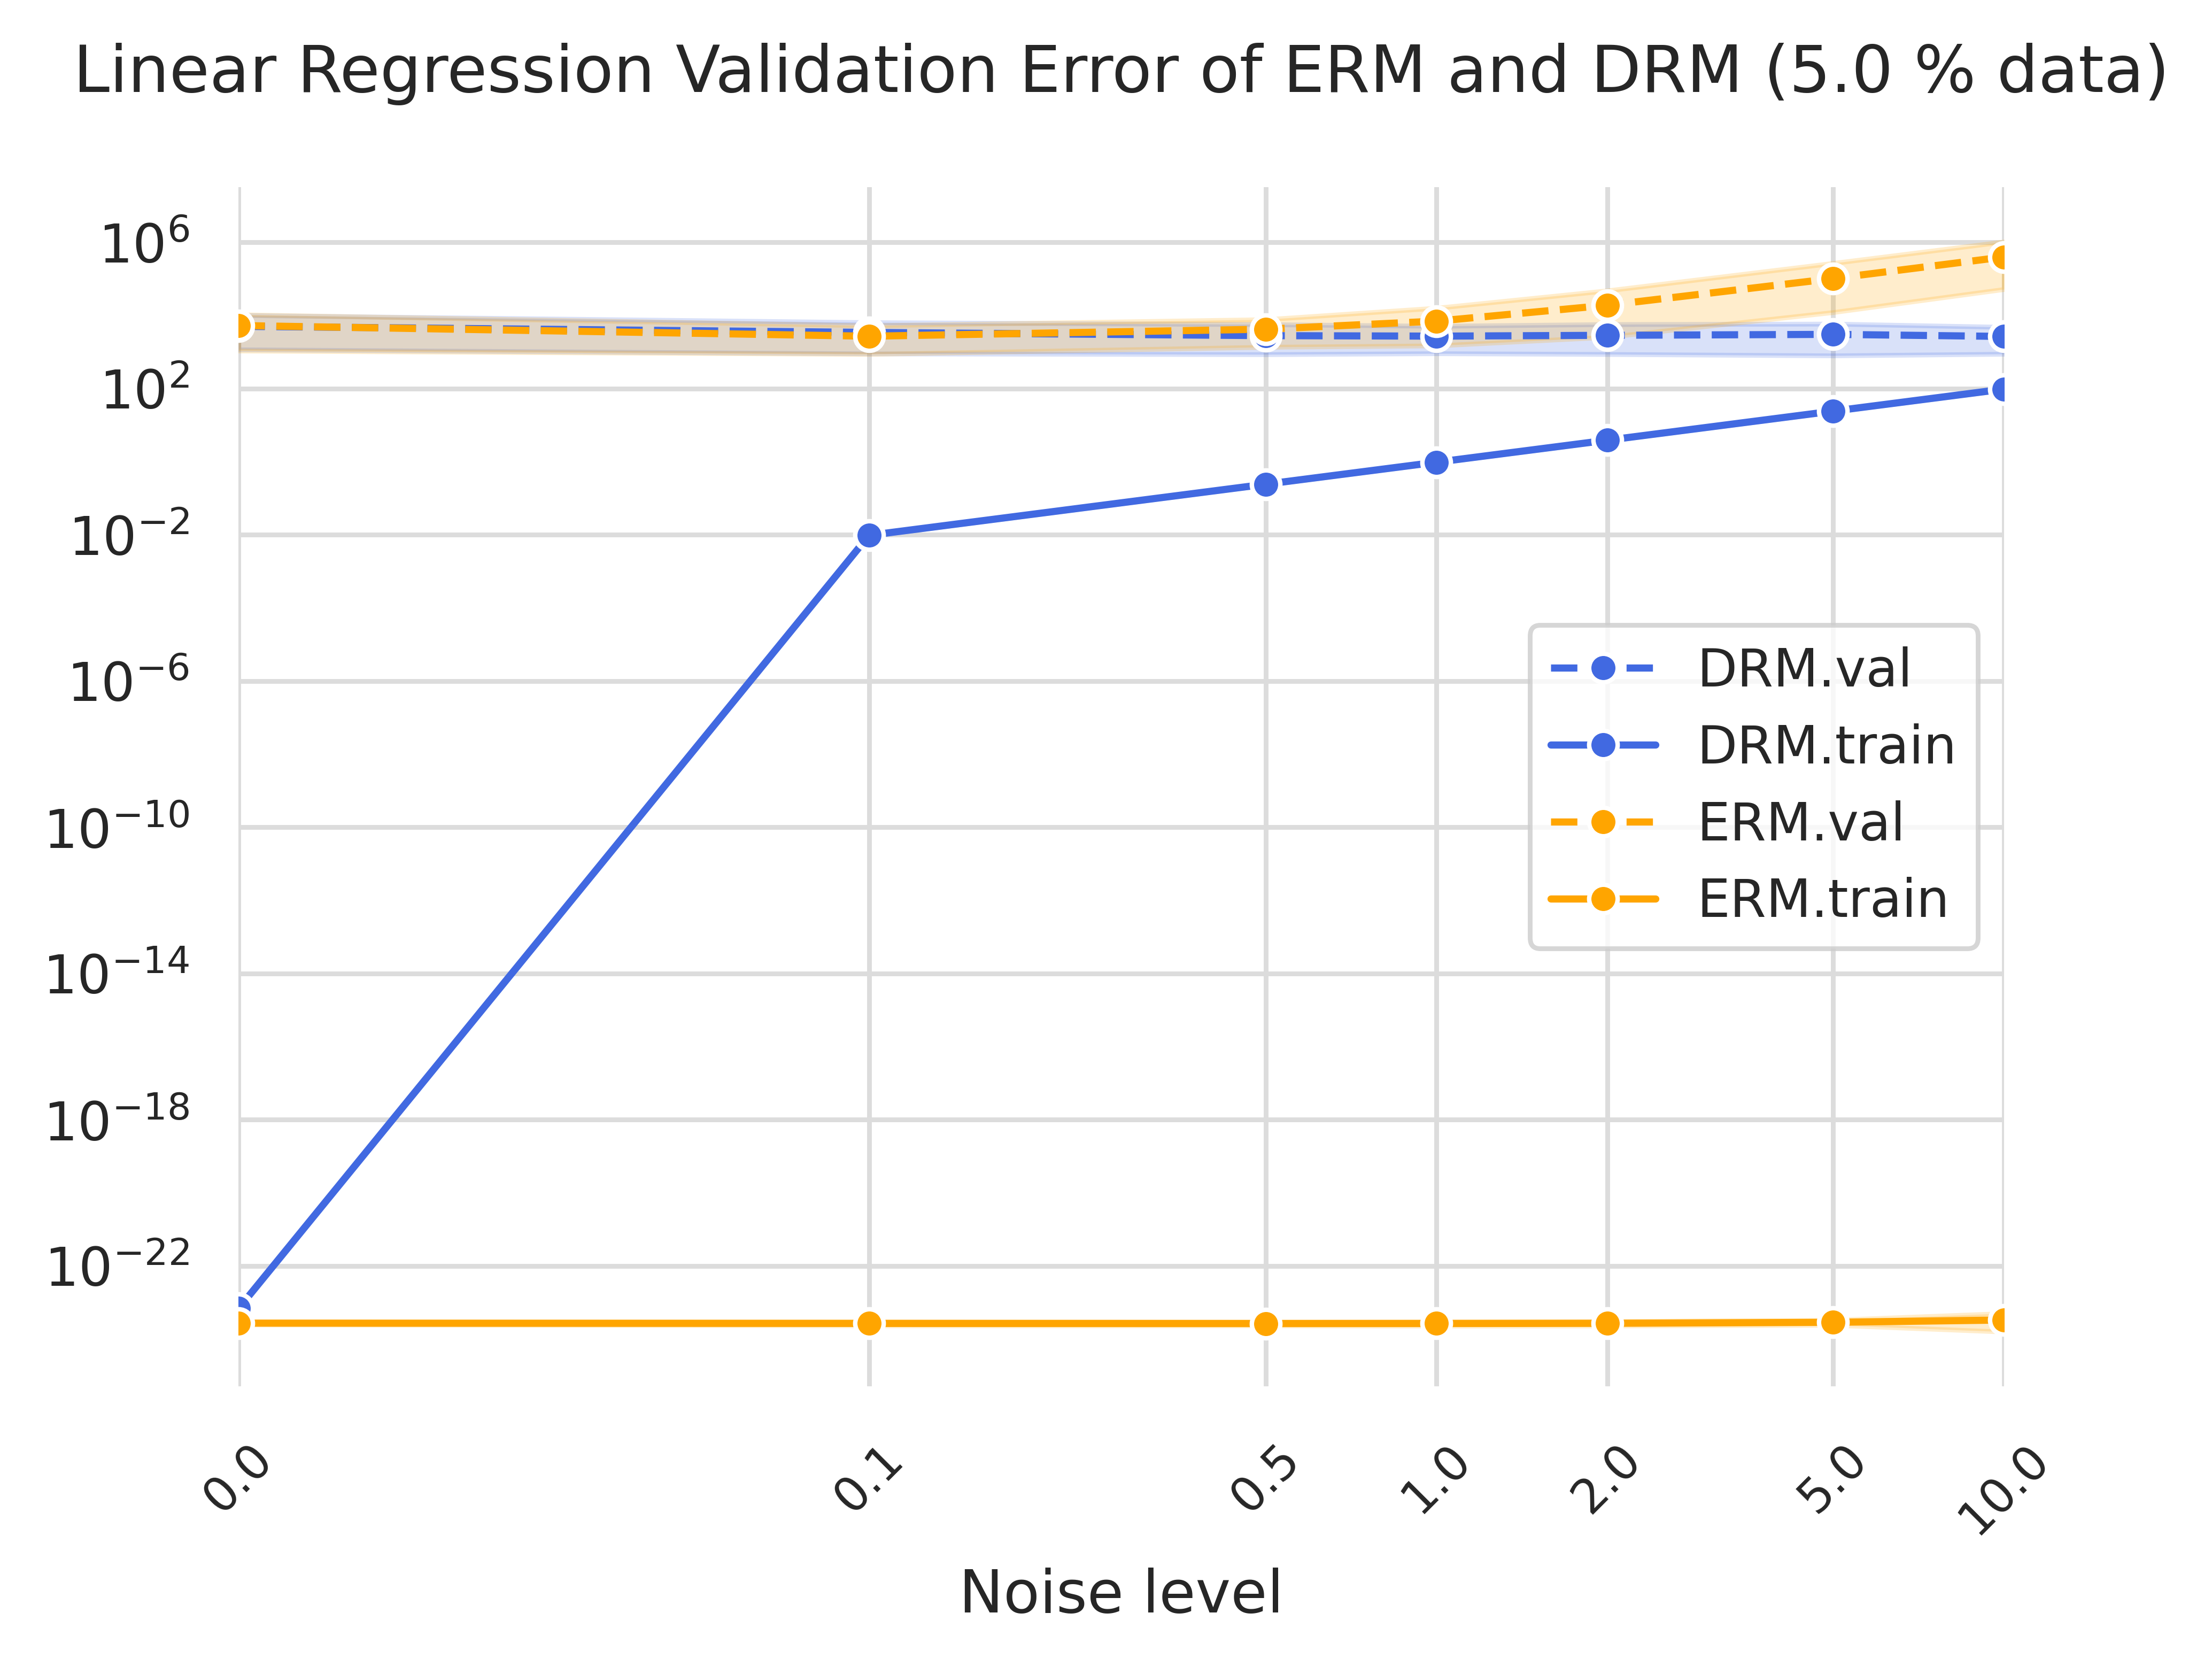

In [186]:
min_max = lambda x: (x.min(), x.max())
data_p = 0.05
working_df = res_df.loc[res_df['buffer_size_p']==data_p]
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="noise", y="final_val_acc_S", errorbar="ci",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    sns.lineplot(data=_df, x="noise", y="final_train_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="noise", y="final_val_acc_S", errorbar="ci",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    sns.lineplot(data=_df, x="noise", y="final_train_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    
    # sns.lineplot(data=_df, x="noise", y="final_val_acc_D", errorbar="ci",
    #             markers=True, marker='o', color='red', ls='--', ax=ax, label="teacher.val")

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    #ax.axhline(teacher_val_accuracy, ls=':', color='red', label="teacher.val")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_yscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    #ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['noise'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['noise'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    # yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    # plt.yticks(yticks)
    # ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    #ax.set_ylim(-100,1000000.0)


    ax.set_title(f"Linear Regression Validation Error of ERM and DRM ({data_p*100} % data)", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Noise level', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM.val',
                  'DRM.train',
                  'ERM.val',
                  'ERM.train',
                  'teacher'], 
                title="", ncol=1, loc="center right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('red')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


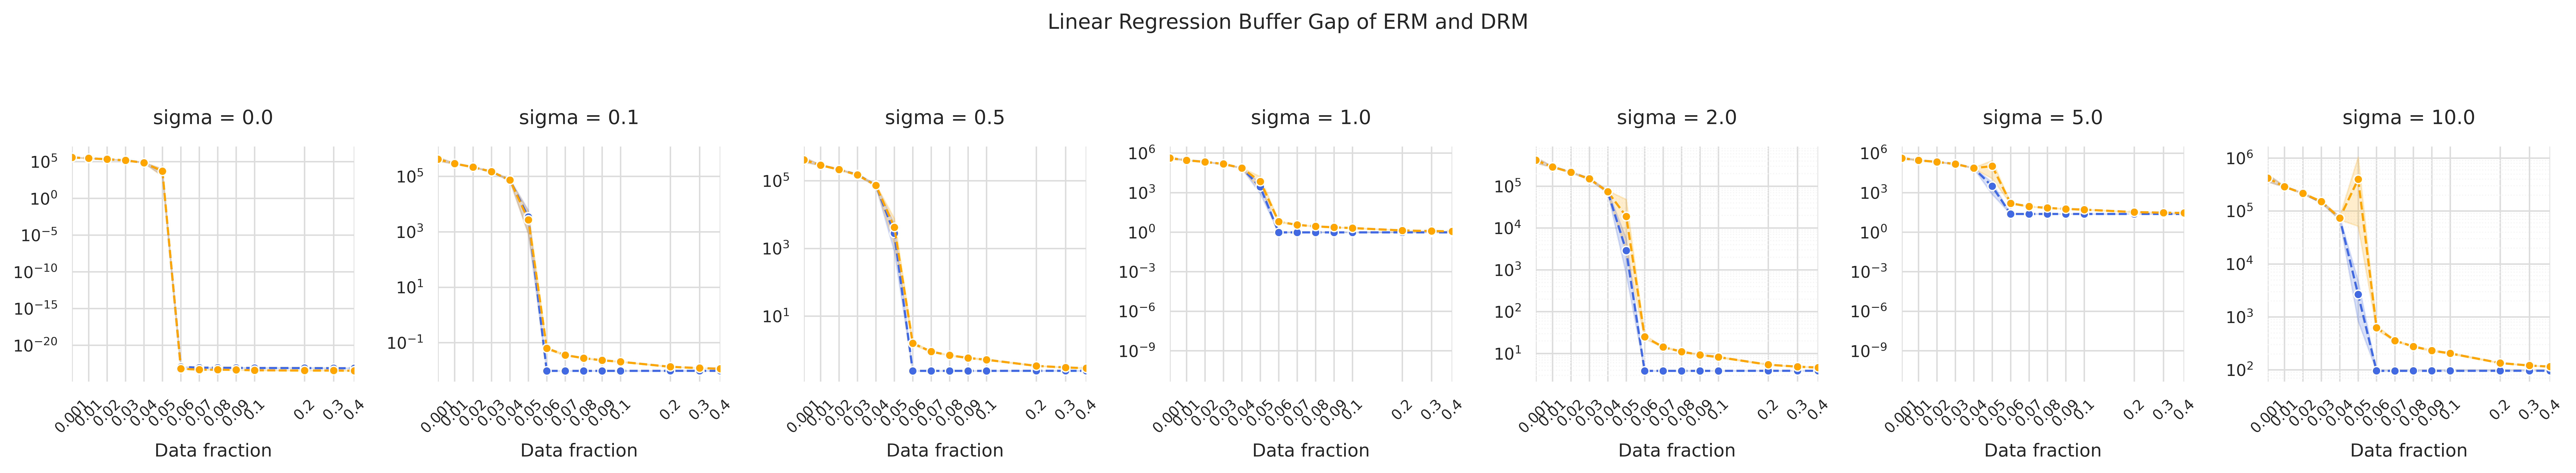

In [187]:
noise_list = sorted(list(res_df['noise'].unique()))

min_max = lambda x: (x.min(), x.max())
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,len(noise_list), figsize=(20,3), sharey=False, dpi=800)
    colors = ['royalblue','orange','dimgray']

    for i, noise in enumerate(noise_list):
      working_df = res_df.loc[res_df['noise']==noise]
      teacher_val_accuracy = list(working_df['final_val_acc_D'])[0]
      _df = working_df.loc[working_df['alpha']==0.0]
      sns.lineplot(data=_df, x="buffer_size_p", y="final_train_leftout_acc_S", errorbar="ci",
                  markers=True, marker='o', color=colors[0], ls='--',ax=ax[i], label="distil.val")
      # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
      #              markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
      _df = working_df.loc[working_df['alpha']==1.0]
      sns.lineplot(data=_df, x="buffer_size_p", y="final_train_leftout_acc_S", errorbar="ci",
                  markers=True, marker='o', color=colors[1], ls='--', ax=ax[i], label="labels.val")
      # sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
      #             markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
      

      #ax.axvline(100.0, ls='--', color='tab:green')
      # ax.axhline(76.034, ls='--', color=colors[2], label="a")
      ax[i].axhline(0.0, ls=':', color='red', label="0")
      # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
      # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
      #            fontsize=10, verticalalignment='top', bbox=props)
      ax[i].set_yscale('log')
      ax[i].set_xscale('symlog',linthresh=10e-2)
      ax[i].set_xlim([0.1,0.4])
      #ax.set_ylim([0.0,100.0])

      ax[i].tick_params(axis='both',  labelsize=9)
      ax[i].set_xticks(working_df['buffer_size_p'].unique())
      ax[i].set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
      ax[i].tick_params(axis='x',  rotation=45)

      # yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
      # plt.yticks(yticks)
      # ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



      # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
      #ax.set_ylim(-100,1000000.0)


      ax[i].set_title(f"sigma = {noise}", fontsize=11, y=1.05)
      ax[i].set_ylabel(r'', fontsize=11, x=-0.2)
      ax[i].set_xlabel(r'Data fraction', fontsize=10, y=+5)


      #ax[t].legend(title="Eigen-index", loc="upper left")
      # Shrink current axis's height by 10% on the bottom
      if i==len(noise_list):
        h, _ = ax.get_legend_handles_labels()
        ax[i].legend(h, ['DRM.val',
                      'ERM.val',
                      'teacher.val'], 
                    title="", ncol=1, loc="upper right")
      else: ax[i].get_legend().remove()


      # AESTHETICS control 
      ax[i].set_facecolor('white')
      [ax[i].spines[side].set_visible(False) for side in ax[i].spines]
      # major and minor grids
      ax[i].grid(which='major', color='gainsboro', linewidth=0.8)
      ax[i].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
      # Make the minor ticks and gridlines show.
      ax[i].minorticks_on()
      #ax.tick_params(which='minor', bottom=False, left=False)
      #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

      # a = ax.get_ygridlines()
      # b = a[3]
      # b.set_color('red')
      # b.set_linewidth(0.8)
      # b.set_linestyle(':')
      #sns.despine()
      plt.tight_layout()
    plt.suptitle("Linear Regression Buffer Gap of ERM and DRM", y=1.2)
